In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
sns.set_style('whitegrid')

# data preprocessing
import re
import json
import string
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# modeling
from sklearn.cluster import KMeans
from kneed import KneeLocator

# utility
from collections import Counter
from itertools import chain
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

In [2]:
# global variable
dataset = 'goodreads.csv'
stopwords = set(stopwords.words('english'))
punctuation = string.punctuation + '—'
min_rating = 2000000
nlp = spacy.load("en_core_web_sm")
vectorizer = TfidfVectorizer()
kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}
sse = []
n_k = range(1, 41)

# Data Loading
---

In [3]:
df = pd.read_csv(dataset) \
    .drop(['web-scraper-order', 'web-scraper-start-url', 'genre', 'genre-href', 'book', 'book-href'], axis=1)
df.head()

,title,author,description,rating,total_rating,list_genre
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D..."
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F..."
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young..."
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti..."
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1121 non-null   object 
 1   author        1121 non-null   object 
 2   description   1120 non-null   object 
 3   rating        1121 non-null   float64
 4   total_rating  1121 non-null   object 
 5   list_genre    1121 non-null   object 
dtypes: float64(1), object(5)
memory usage: 52.7+ KB


# Data Cleaning
---

Since we can't visualize with dirty data, we need to clean the data first so we can do EDA with ease. First we need to clean the *total_rating* columns and convert to int.

In [5]:
df.dropna(inplace=True)

In [6]:
# clean the rating column by removing "ratings" and convert to int
df['total_rating_clean'] = df['total_rating'].apply(lambda x: re.sub(',(?!\s+\d$)', '', x[:-8])).astype(np.int64)
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 1120
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1120 non-null   object 
 1   author              1120 non-null   object 
 2   description         1120 non-null   object 
 3   rating              1120 non-null   float64
 4   total_rating        1120 non-null   object 
 5   list_genre          1120 non-null   object 
 6   total_rating_clean  1120 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 70.0+ KB


In [8]:
df.describe()

,rating,total_rating_clean
count,1120.000000,1.120000e+03
mean,4.140589,2.941330e+05
std,0.278698,7.273204e+05
min,2.000000,2.000000e+00
25%,3.960000,8.667500e+02
50%,4.150000,2.988100e+04
75%,4.340000,2.267212e+05
max,4.890000,8.889571e+06


Next lets move to *list_genre* columns. We need to convert from json object to list of genre

In [9]:
# clean the genre from json object to dictionary and convert to list
df['list_genre_clean'] = df['list_genre'].apply(lambda x: [dict_genre['list_genre'] for dict_genre in json.loads(x)])
df['list_genre_clean'] = df['list_genre_clean'].apply(lambda x: ['-'.join(genre.split()) for genre in x[:-1]])
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie..."
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict..."
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre..."
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre..."
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 1120
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1120 non-null   object 
 1   author              1120 non-null   object 
 2   description         1120 non-null   object 
 3   rating              1120 non-null   float64
 4   total_rating        1120 non-null   object 
 5   list_genre          1120 non-null   object 
 6   total_rating_clean  1120 non-null   int64  
 7   list_genre_clean    1120 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 78.8+ KB


In [11]:
def strip_html(text):
    """
    This function strip html tags from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from html
    """
    
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stopwords(text):
    """
    This function remove stopwords from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from stopwords
    """
    
    text = text.split()
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

def remove_digits(text):
    """
    This function remove number/digits from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from number/digits
    """
    
    text = re.sub(r'[0-9]', '', text)
    return text

def remove_punctuation(text):
    """
    This function remove punctuation from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from punctuation
    """
    
    text = ''.join([word for word in text if word not in punctuation])
    return text

def get_keywords(text):
    """
    This function get keywords from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: list of keywords
    """
    
    doc = nlp(text)
    return ' '.join([item.text.strip() for item in doc.ents])

def parse_text(text):
    """
    This function parse the text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: parsed text
    """
    
    text = text.lower()
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_punctuation(text)
    text = get_keywords(text)
    return text

In [12]:
df['keywords'] = df['description'].apply(parse_text)
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean,keywords
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss initiation day new york second dysto...
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first one today swan one new york times new mo...
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter harry harry returns weeks sixth year
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter come harry harry one harry potter
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...


# Exploratory Data Analysis
---

The dataset contains 1121 row and 6 columns (after dropping irelevant column) with following information :
* title : title of the book (object)
* author : author of the book (object)
* description : description of the book not synopsis (object)
* rating : average rating given to the book (float)
* total_rating : total rating given to the book (object)
* list_genre : genre of the book (object)

In [13]:
print(f'The goodreads dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

The goodreads dataset contains 1120 rows and 9 columns


Based on the information we get from the dataset, it contains 1 missing value in description column. We can drop the missing value since its only 1 data missing

In [14]:
df.dropna(inplace=True)
print(f'After dropping missing value, the goodreads dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

After dropping missing value, the goodreads dataset contains 1120 rows and 9 columns


In [15]:
print('Book unique value:', len(df['title'].unique()))
print('Author unique value:', len(df['author'].unique()))

Book unique value: 1120
Author unique value: 898


As we can see, some author have more than 1 books. Lets see which author have the most book

In [16]:
def bar_chart(x, y, title=None, sc=False, xlabel=None, ylabel=None):
    """
    This function plot categorical distribution using seaborn barplot
    
    Parameters
    ----------
    x: x axis values
    y: y axis values
    title: title of the plot
    
    Returns
    ----------
    None
    """
    
    plt.figure(figsize=(15,8))
    if not sc:
        plt.ticklabel_format(style='plain', axis='x')
    ax = sns.barplot(x=x, y=y, palette='mako')
    ax.set_title(title, pad=20, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

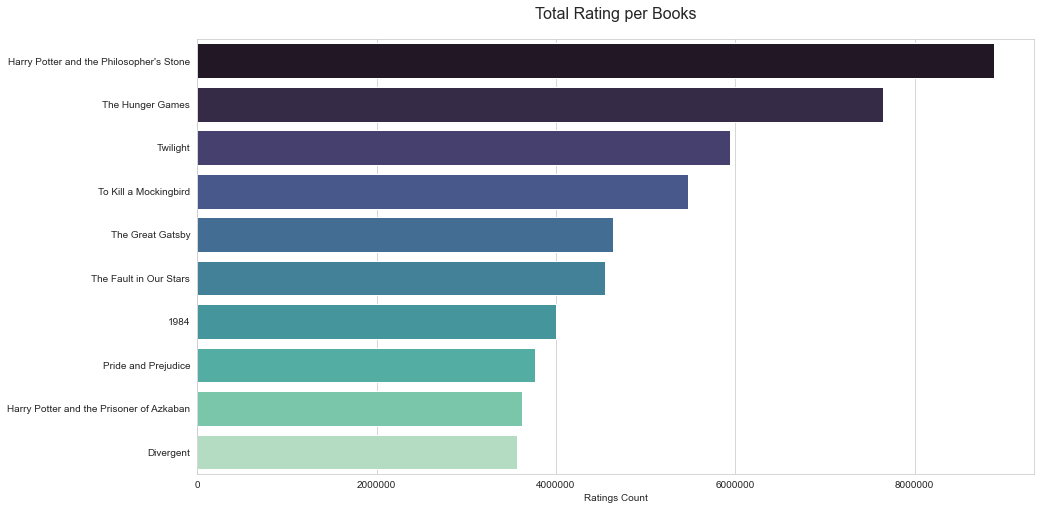

In [17]:
top_10_rated_book = df.sort_values('total_rating_clean', ascending=False).head(10).set_index('title')
bar_chart(
    x=top_10_rated_book['total_rating_clean'], 
    y=top_10_rated_book.index, 
    title='Total Rating per Books',
    xlabel='Ratings Count'
)

From the plot above we can conclude that:
1. Usually the beginning books of the series have the most rating, i.e Harry Potter and the Phiolosopher Stone, The Hunger Games, Twilight.
2. J.K Rowling dominates the most rated books chart with Harry Potter and the Philosopher's Stone and Harry Potter and the Prisoner of Azkaban with over than 12 million rating on GoodReads.

In [18]:
rating_mean = np.mean(df['rating'])

In [19]:
def weighted_rating(R, v, C=rating_mean, m=min_rating):
    """
    This function used to get book weighted rating based on IMDB movie weighted rating, where :
    W = (Rv + Cm) / (v + m)
    
    Parameters
    ----------
    R: average book rating
    v: total number of rating
    C: rating means for all books
    m: minimum total number of rating
    
    Returns
    ----------
    W: weighted rating
    """
    
    W = (R * v) + (C * m) / (v + m)
    return W

In [20]:
df['weighted_rating'] = weighted_rating(df['rating'], df['total_rating_clean']) / 1e6
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean,keywords,weighted_rating
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss initiation day new york second dysto...,5.486643
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first one today swan one new york times new mo...,6.254602
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter harry harry returns weeks sixth year,13.464377
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter come harry harry one harry potter,15.221145
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...,13.662515


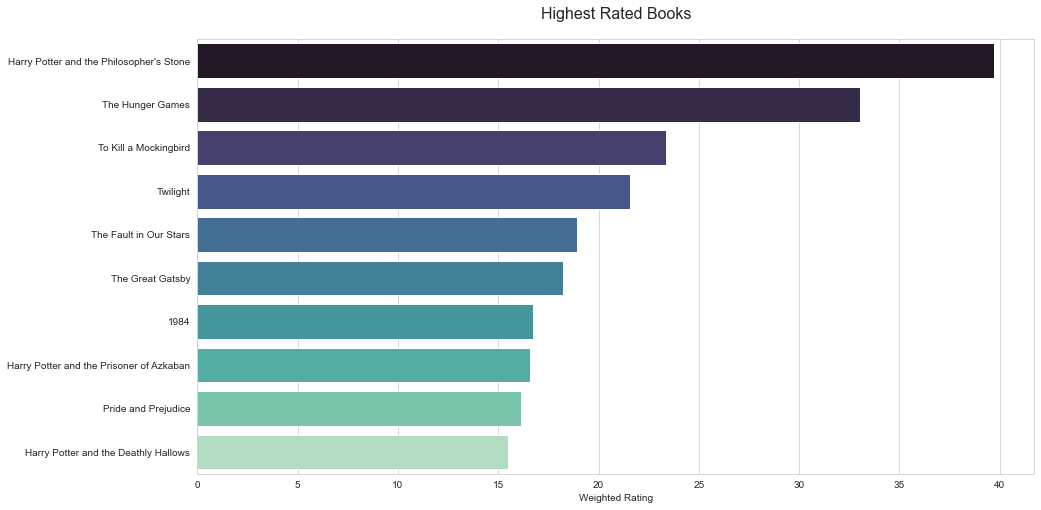

In [21]:
top_10_books = df.sort_values('weighted_rating', ascending=False).head(10).set_index('title')
bar_chart(
    x=top_10_books['weighted_rating'], 
    y=top_10_books.index, 
    title='Highest Rated Books',
    xlabel='Weighted Rating'
)

From this plot we can compare to plot before, we can see that some book with most total rating is not in the highest rated books chart. We can conclude that having that much number of rating doesnt make the book the highest rated books.

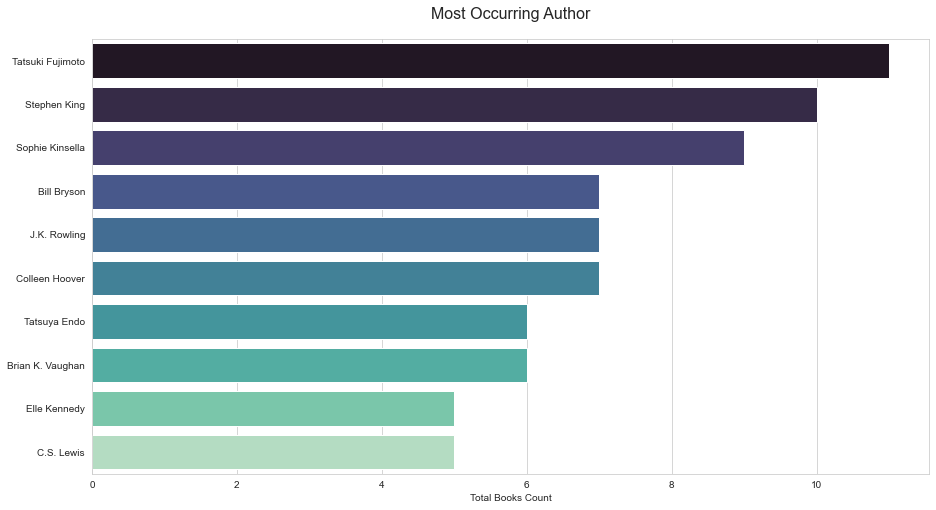

In [22]:
top_10_most_author = df['author'].value_counts().sort_values(ascending=False)[:10]
bar_chart(
    y=top_10_most_author.index, 
    x=top_10_most_author.values, 
    title='Most Occurring Author',
    xlabel='Total Books Count'
)

In [23]:
most_occur_author = df.loc[df['author'] == 'Tatsuki Fujimoto'][['title', 'rating', 'total_rating_clean', 'weighted_rating']]
most_occur_author

,title,rating,total_rating_clean,weighted_rating
644,チェンソーマン 10,4.47,7760,0.034691
645,チェンソーマン 9,4.62,8189,0.037837
646,チェンソーマン 11,4.51,7324,0.033035
647,チェンソーマン 8,4.41,8247,0.036373
649,チェンソーマン 7,4.36,8639,0.037670
650,チェンソーマン 6,4.43,9374,0.041531
651,チェンソーマン 5,4.36,10120,0.044127
652,チェンソーマン 4,4.38,11394,0.049910
653,チェンソーマン 3,4.33,12870,0.055731
654,"Chainsaw Man, Vol. 1: Dog And Chainsaw",4.36,40427,0.176266


As we can see Tatsuki Fujimoto has the most book with 11 book, followed by Stephen King with 10 book and Sophie Kinsella with 9 book. Although Tatsuki Fujimoto has the most books he didnt manage to enter the most rated books chart. Because his books not for everyone, only Manga lover.

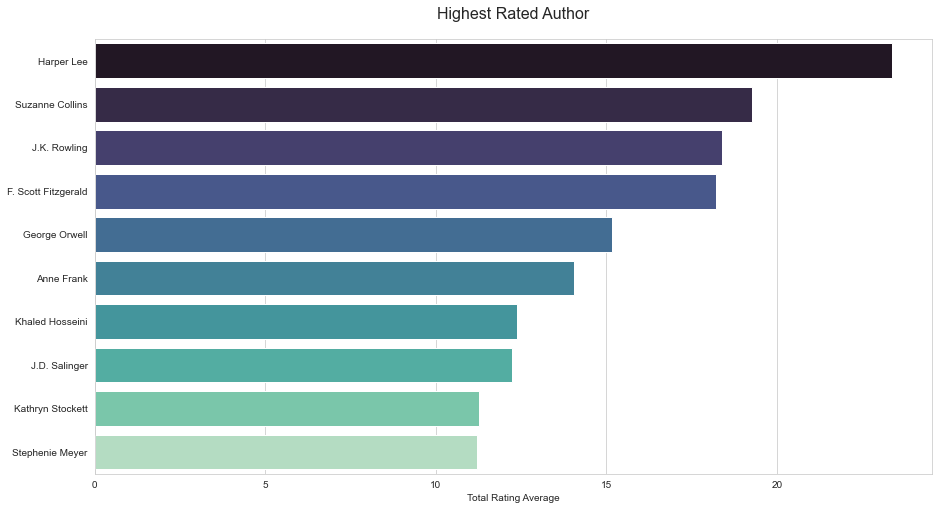

In [24]:
top_rated_author = df.groupby('author')['weighted_rating'].agg(np.mean).sort_values(ascending=False)[:10]
bar_chart(
    y=top_rated_author.index, 
    x=top_rated_author.values, 
    title='Highest Rated Author',
    xlabel='Total Rating Average'
)

In [25]:
highest_rated_author = df.loc[df['author'] == 'Harper Lee'][['title', 'rating', 'total_rating_clean', 'weighted_rating']]
highest_rated_author

,title,rating,total_rating_clean,weighted_rating
763,To Kill a Mockingbird,4.27,5472205,23.366316


From this plot, we can conclude that the highest rated author has a high rated book which is "To Kill a Mockingbird". Even though the author only have 1 book, she can compete with other author that have more book than her.

In [26]:
def create_wordcloud(data):
    """
    This function used to create wordcloud from given data
    
    Parameters
    ----------
    data: a set of string/text
    
    Returns
    ----------
    None
    """
    
    wordcloud = WordCloud(
        width=1500,
        height=800,
        min_font_size=12,
        background_color='white'
    ).generate(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

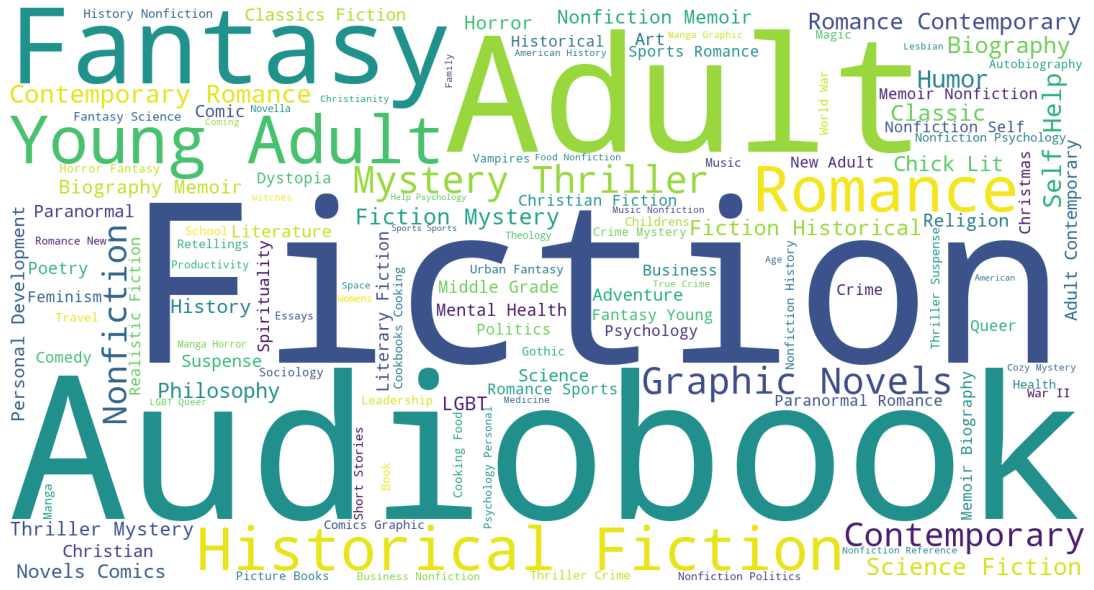

In [27]:
joined_genre = ' '.join(df['list_genre_clean'].apply(lambda x: ' '.join(x)).values)
create_wordcloud(joined_genre)

From the wordcloud above we can see that most books have Fiction genre, followed by Adult and Audiobook. For more clear visualisation, we can plot how many books for each genre.

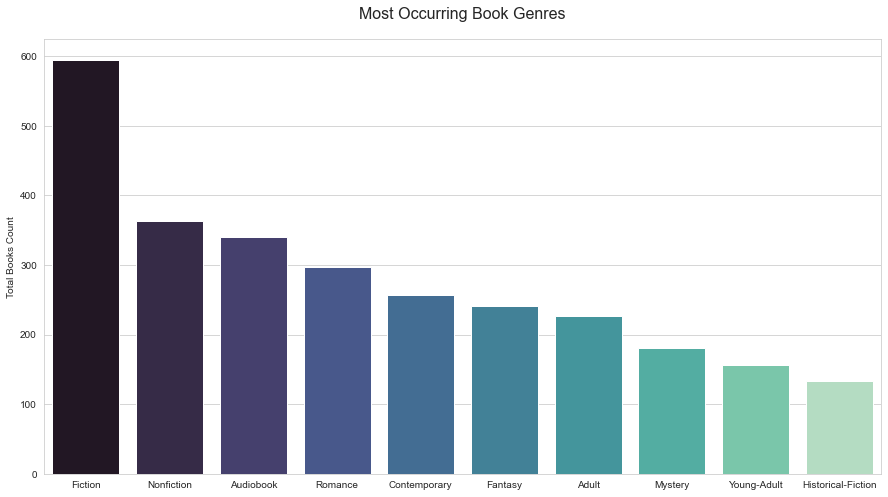

In [28]:
genre_list = df['list_genre_clean'].values
genres = list(chain.from_iterable(genre_list))
top_10_genre = Counter(genres).most_common(10)
bar_chart(
    x=[genre for (genre, count) in top_10_genre],
    y=[count for (genre, count) in top_10_genre],
    title='Most Occurring Book Genres',
    ylabel='Total Books Count'
)

From the wordcloud we can see that Fiction is the most occurring genre from the books followed by Adult. But from this plot Adult is the 4th last total books. From these plot we can conclude that many user like Fiction books for entertainment purposes. Lets see the distribution rating for Fiction book.

In [29]:
top_genre = ['Fiction']
fiction_book = df.loc[df['list_genre_clean'].apply(lambda x: any(set(x).intersection(top_genre)))]
fiction_book.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean,keywords,weighted_rating
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss initiation day new york second dysto...,5.486643
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first one today swan one new york times new mo...,6.254602
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter harry harry returns weeks sixth year,13.464377
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter come harry harry one harry potter,15.221145
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...,13.662515


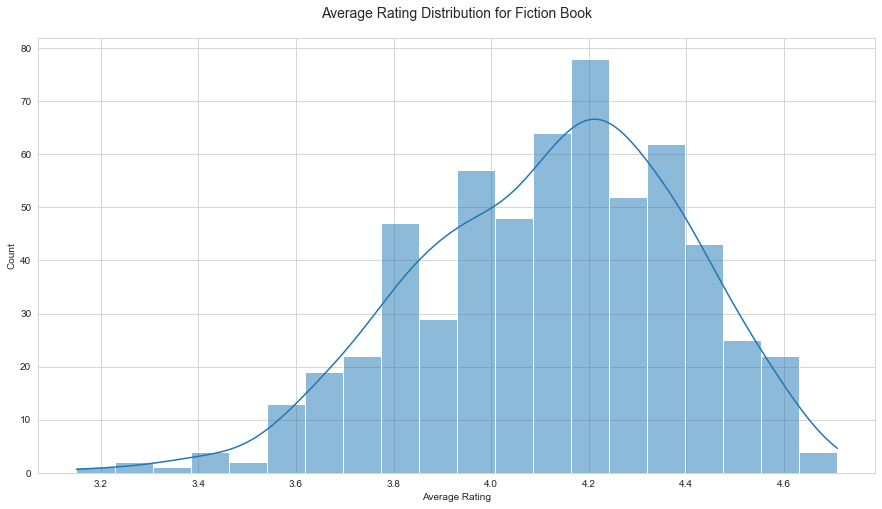

In [30]:
plt.figure(figsize=(15,8))
sns.histplot(data=fiction_book, x='rating', kde=True, bins=20)
plt.title('Average Rating Distribution for Fiction Book', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.show()

From the plot above we can conclude that the rating of Fiction books around 3.9 - 4.4 which is pretty good Fiction book.

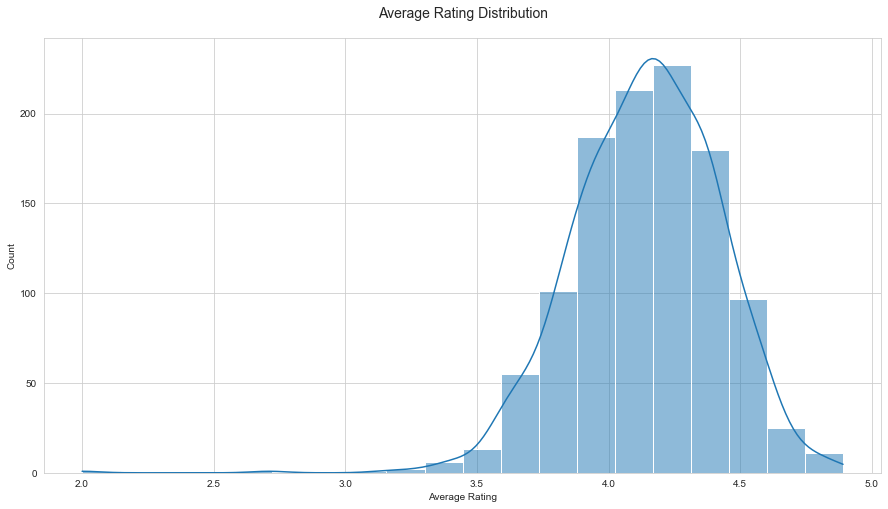

In [31]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x='rating', kde=True, bins=20)
plt.title('Average Rating Distribution', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.show()

From the given plot, we can conclude that :
* Majority of average rating lie near 3.8-4.6, approximately
* No books have average rating of 5

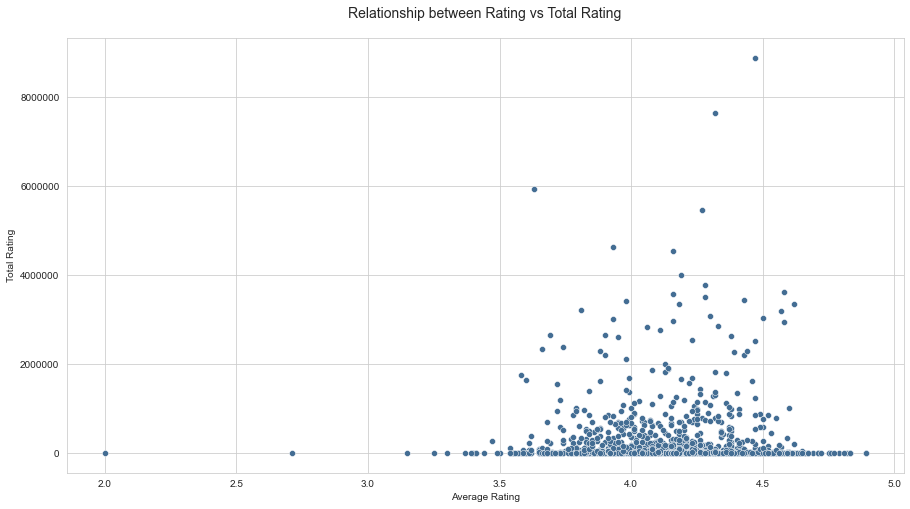

In [32]:
plt.figure(figsize=(15,8))
sns.scatterplot(y='total_rating_clean', x='rating', data=df, color='#436D93')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Relationship between Rating vs Total Rating', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Total Rating')
plt.show()

From the plot above there is seem to be some outliers present in this. For a better outlook, lets consider the total rating around 2 million

In [33]:
temp = df[~(df['total_rating_clean'] > min_rating)]
temp.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean,keywords,weighted_rating
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss initiation day new york second dysto...,5.486643
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first one today swan one new york times new mo...,6.254602
15,The Road to Bittersweet,Donna Everhart,SOUTHEASTERN LIBRARY ASSOCIATION'S (SELA) 2018...,4.18,"3,115 ratings","[{""list_genre"":""Historical Fiction""},{""list_ge...",3115,"[Historical-Fiction, Fiction, Southern, Coming...",winter siba trio selection siba okra pick win...,0.013025
16,Betrayal,Ivy Smoak,Matthew Caldwell is the only thing keeping me ...,4.18,"6,312 ratings","[{""list_genre"":""Romance""},{""list_genre"":""Young...",6312,"[Romance, Young-Adult, High-School, Contempora...",matthew caldwell,0.026388
17,To Kill a Kingdom,Alexandra Christo,Princess Lira is siren royalty and the most le...,3.79,"140,324 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",140324,"[Fantasy, Young-Adult, Romance, Retellings, Yo...",lira siren seventeen one one winter,0.531832


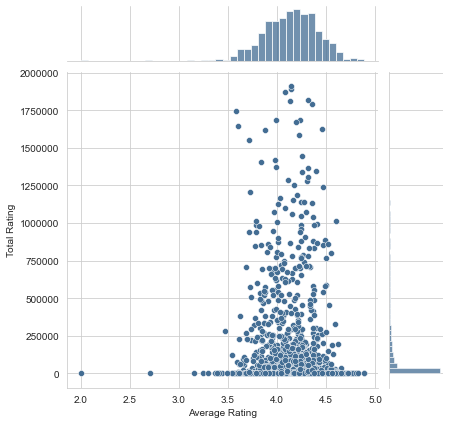

In [34]:
ax = sns.jointplot(x='rating', y='total_rating_clean', data=temp, color='#436D93')
plt.ticklabel_format(style='plain', axis='y')
ax.set_axis_labels('Average Rating', 'Total Rating')
plt.show()

From the plot above, we can see that there might be potensial relationship between average rating and total rating. As the number of total rating increase, the rating for the book seems taper towards 4.

# Feature Selection
---

Because we are using Content Based Approach, the feature we are subseting is title, author, genre, and keywords.

In [35]:
features = ['title', 'author', 'list_genre_clean', 'keywords']
final_df = df.loc[:, features]
final_df['list_genre_clean'] = final_df['list_genre_clean'].apply(lambda x: ' '.join(x))
final_df['keywords'] = final_df['keywords'].apply(lambda x: ' '.join(list(set(x.split()))))
final_df.head()

,title,author,list_genre_clean,keywords
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one initiation triss dystopian second new day ...
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie meyer today moon times first new...
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,potter harry weeks sixth returns year
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,potter harry one come
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays potter ron harry hermione fift...


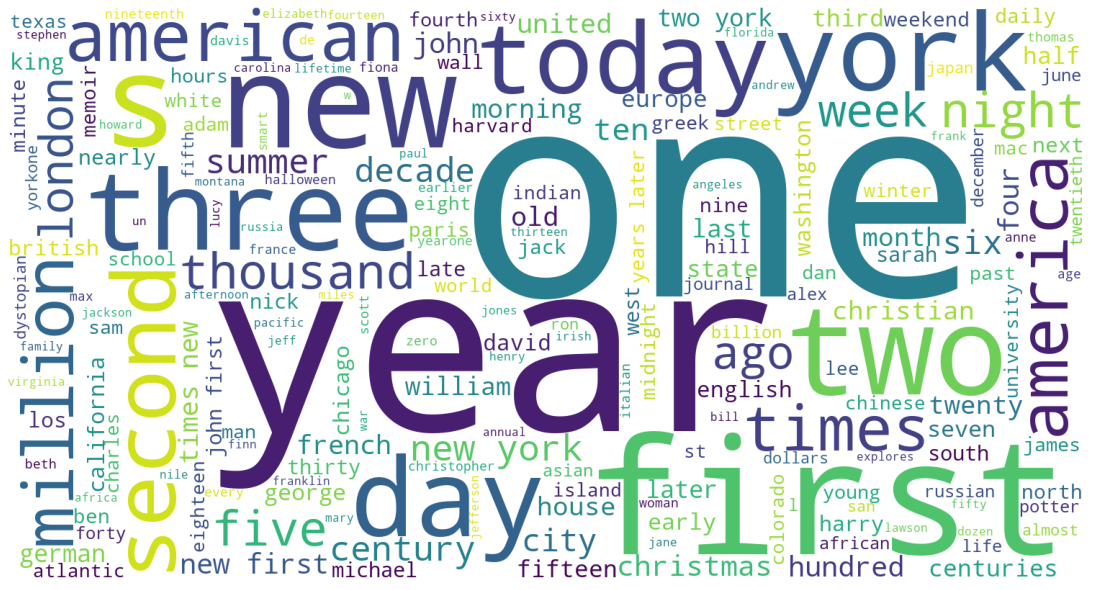

In [36]:
joined_keyword = ''.join(final_df['keywords'].values)
create_wordcloud(joined_keyword)

From the wordcloud above, we can see that "year" is the most occurred keywords of all books. It can happens because in most books description starting with telling the year of the books. Next we can create a corpus from book genre and keywords to find the frequency of corpus between books. We are using TfidfVectorizer to find the corpus frequency and convert it to vector array.

In [37]:
final_df['corpus'] =  final_df[['list_genre_clean', 'keywords']].agg(' '.join, axis=1).str.lower()
final_df.head()

,title,author,list_genre_clean,keywords,corpus
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one initiation triss dystopian second new day ...,young-adult dystopia fiction fantasy science-f...
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie meyer today moon times first new...,young-adult fantasy romance vampires fiction p...
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,potter harry weeks sixth returns year,fantasy young-adult fiction magic childrens ad...
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,potter harry one come,fantasy fiction young-adult magic childrens mi...
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays potter ron harry hermione fift...,fantasy young-adult fiction magic childrens ad...


In [38]:
tfidf = vectorizer.fit_transform(final_df['corpus'])
tfidf

<1120x3475 sparse matrix of type '<class 'numpy.float64'>'
	with 16169 stored elements in Compressed Sparse Row format>

After getting the frequency, then we need to find the similarity between vector for clustering. We will use cosine similarity to find similarity between vector.

In [39]:
cosine_sim = cosine_similarity(tfidf, tfidf)
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119
0,1.000000,0.169077,0.149771,0.115447,0.136285,0.149001,0.144654,0.143588,0.111372,0.224806,...,0.067144,0.064934,0.0,0.0,0.012547,0.076002,0.101733,0.000000,0.063798,0.086676
1,0.169077,1.000000,0.067126,0.091507,0.061081,0.066781,0.064832,0.064355,0.086768,0.513254,...,0.052299,0.042188,0.0,0.0,0.010940,0.045254,0.065770,0.101586,0.065660,0.062288
2,0.149771,0.067126,1.000000,0.513052,0.519464,0.508817,0.534908,0.530968,0.557499,0.093577,...,0.020404,0.026664,0.0,0.0,0.000000,0.000000,0.038847,0.000000,0.055915,0.015114
3,0.115447,0.091507,0.513052,1.000000,0.466854,0.510415,0.620836,0.616264,0.830895,0.107086,...,0.036402,0.030513,0.0,0.0,0.014247,0.000000,0.060386,0.000000,0.063987,0.031184
4,0.136285,0.061081,0.519464,0.466854,1.000000,0.463000,0.751624,0.677781,0.507298,0.085151,...,0.018567,0.024263,0.0,0.0,0.000000,0.000000,0.035349,0.000000,0.050880,0.013753


# Modeling
---

After getting the distance between item in vector, we feed the data into KMeans and run for 40 iteration to get the sse for finding the best k (elbow) using KneeLocator.

In [40]:
for k in n_k:
    print(f'Cluster {k}/40')
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(cosine_sim)
    sse.append(kmeans.inertia_)
    clear_output(wait=True)
locator = KneeLocator(n_k, sse, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator.elbow)

Best cluster for KMeans: 8


In [41]:
kmeans = KMeans(n_clusters=locator.elbow, **kmeans_params)
kmeans.fit(cosine_sim)
final_df['cluster'] = kmeans.labels_
final_df.head()

,title,author,list_genre_clean,keywords,corpus,cluster
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one initiation triss dystopian second new day ...,young-adult dystopia fiction fantasy science-f...,4
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie meyer today moon times first new...,young-adult fantasy romance vampires fiction p...,4
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,potter harry weeks sixth returns year,fantasy young-adult fiction magic childrens ad...,4
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,potter harry one come,fantasy fiction young-adult magic childrens mi...,4
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays potter ron harry hermione fift...,fantasy young-adult fiction magic childrens ad...,4


As we can see from the dataframe above, the 5 first book clustered to 4 and that we doesnt know about. Then we plot the cluster similarity for book 0 between all book and book 1 between all book.

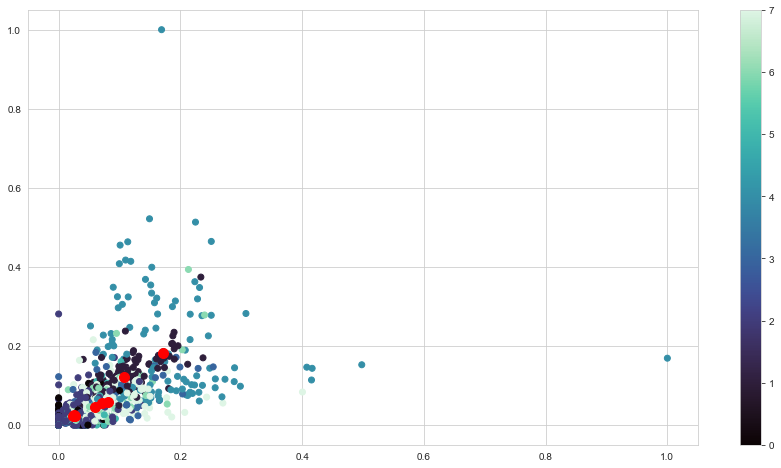

In [42]:
plt.figure(figsize=(15,8))
output = plt.scatter(cosine_sim[:,0], cosine_sim[:,1], c=final_df.cluster, marker='o', alpha=1, cmap='mako')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=100, alpha=1 , marker='o')
plt.colorbar(output)
plt.show()

As we can see, based on the plot we notice that most of the book grouping on the bottom left side. This shows that all books almost have the same similarity between each other. Based on the dataframe before, we can see the top 5 all books clustered to 4. Now lets see all the book with cluster 4.

In [43]:
cluster_4 = final_df.loc[final_df['cluster'] == 4, :]
cluster_4.head()

,title,author,list_genre_clean,keywords,corpus,cluster
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one initiation triss dystopian second new day ...,young-adult dystopia fiction fantasy science-f...,4
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie meyer today moon times first new...,young-adult fantasy romance vampires fiction p...,4
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,potter harry weeks sixth returns year,fantasy young-adult fiction magic childrens ad...,4
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,potter harry one come,fantasy fiction young-adult magic childrens mi...,4
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays potter ron harry hermione fift...,fantasy young-adult fiction magic childrens ad...,4


Now lets get 1 book from final_df for test the recommendation system then we create book map for getting book recommendation based on title given. And return the book index if the book given exists in dataset.

In [44]:
test_book = final_df.sample(1, random_state=123)
test_book

,title,author,list_genre_clean,keywords,corpus,cluster
685,You Deserve Each Other,Sarah Hogle,Romance Contemporary Contemporary-Romance Adul...,three fiancé nicholas two months,romance contemporary contemporary-romance adul...,1


In [45]:
book_map = pd.Series(final_df.index, index=final_df['title'])
book_map.head()

title
Insurgent                                    0
New Moon                                     1
Harry Potter and the Half-Blood Prince       2
Harry Potter and the Chamber of Secrets      3
Harry Potter and the Order of the Phoenix    4
dtype: int64

In [46]:
def get_recommendation(title, top_n=11):
    """
    This function get recommendation from given book title
    
    Parameters
    ----------
    title: a text of book title
    top_n: (default 11) how much book want to get recommendation - given book title
    
    Returns
    ----------
    top_n_recommendation: a DataFrame contains recommended book
    """
    
    # get index from input title
    book_id = book_map[title]
    
    # calculate similarity score, sort value descending and get top_n book
    sim_score = list(enumerate(cosine_sim[book_id]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[:top_n]
    
    # get book index from top_n recommendation
    book_indices = [score[0] for score in sim_score]
    scores = [score[1] for score in sim_score]
    top_n_recommendation = final_df[['title', 'author', 'list_genre_clean']].iloc[book_indices]
    top_n_recommendation['list_genre_clean'] = top_n_recommendation['list_genre_clean'].apply(lambda x: x.split())
    top_n_recommendation['score'] = scores
    return top_n_recommendation.iloc[1:]

In [47]:
test_title = test_book['title'].values[0]
pd.set_option('display.max_colwidth', None)
test_df = final_df[['title', 'author', 'list_genre_clean', 'cluster']].loc[final_df['title'] == test_title]
test_df['list_genre_clean'] = test_df['list_genre_clean'].apply(lambda x: x.split())
test_df

,title,author,list_genre_clean,cluster
685,You Deserve Each Other,Sarah Hogle,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, Chick-Lit, Audiobook]",1


In [48]:
recommendation = get_recommendation(test_title)
recommendation

,title,author,list_genre_clean,score
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.562408
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.532802
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.528233
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.505268
1042,Confessions of a Shopaholic,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Adult-Fiction]",0.482743
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.479653
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.453525
692,In a Jam,Kate Canterbary,"[Romance, Contemporary-Romance, Contemporary, Adult, Fiction, Humor, Chick-Lit]",0.428363
341,Beach Read,Emily Henry,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Audiobook]",0.407536
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.392074


After getting the recommendation lets check if the recommended book is in the cluster 1.

In [49]:
recommendation['cluster'] = recommendation['title'].apply(
    lambda x: final_df.loc[final_df['title'] == x, 'cluster'].values[0] \
    if x in final_df['title'].values.tolist() else False)
recommendation

,title,author,list_genre_clean,score,cluster
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.562408,1
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.532802,1
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.528233,1
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.505268,1
1042,Confessions of a Shopaholic,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Adult-Fiction]",0.482743,1
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.479653,1
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.453525,1
692,In a Jam,Kate Canterbary,"[Romance, Contemporary-Romance, Contemporary, Adult, Fiction, Humor, Chick-Lit]",0.428363,1
341,Beach Read,Emily Henry,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Audiobook]",0.407536,1
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.392074,1


As we can see all the recommended book is on cluster 1. We can conclude that the recommendation give the relevant item based on given title

# Evaluation
---

For evaluation Content Based Approach, we gonna use precision@k. Basically, count the relevant item from all recommended item. Usually precision@k use the rating, since we dont have a rating from user we gonna use the similarity score between recommended book and given book. If the score > 0,5 then the book is relevant.

In [50]:
eval_title = 'Harry Potter and the Chamber of Secrets'
high_score = get_recommendation(eval_title)
high_score

,title,author,list_genre_clean,score
8,Harry Potter and the Philosopher's Stone,J.K. Rowling,"[Fantasy, Fiction, Young-Adult, Magic, Childrens, Middle-Grade, Classics]",0.830895
6,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,"[Fantasy, Fiction, Young-Adult, Magic, Childrens, Middle-Grade, Adventure]",0.620836
7,Harry Potter and the Goblet of Fire,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Middle-Grade, Adventure]",0.616264
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook]",0.513052
1026,Shad Hadid and the Alchemists of Alexandria,George Jreije,"[Middle-Grade, Fantasy, Adventure, Magic, Young-Adult, Fiction, Childrens]",0.511671
5,Harry Potter and the Deathly Hallows,J.K. Rowling,"[Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook, Fantasy]",0.510415
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook]",0.466854
697,The Book That No One Wanted to Read,Richard Ayoade,"[Middle-Grade, Childrens, Humor]",0.457318
1001,Matilda,Roald Dahl,"[Childrens, Fiction, Classics, Fantasy, Middle-Grade, Young-Adult, Humor]",0.436953
997,The Secret Garden,Frances Hodgson Burnett,"[Classics, Fiction, Childrens, Young-Adult, Historical-Fiction, Middle-Grade, Fantasy]",0.382813


In [51]:
score = recommendation['score']
score

581     0.562408
357     0.532802
1030    0.528233
1038    0.505268
1042    0.482743
583     0.479653
67      0.453525
692     0.428363
341     0.407536
1029    0.392074
Name: score, dtype: float64

In [52]:
test_cluster = test_df['cluster'].values[0]
print('The cluster for test data is:', test_cluster)

The cluster for test data is: 1


In [53]:
def get_relevant_items(cluster, score, threshold=0.5):
    """
    This function used to calculate total relevant items
    
    Parameters
    ----------
    cluster: test cluster to get relevant item
    
    Returns
    ----------
    relevant_item: a dataframe contain relevant items
    """
    
    relevant_item = recommendation.loc[(recommendation['cluster'] == cluster) & (score > threshold)]
    return relevant_item

def get_recommended_items(k):
    """
    This function used to calculate total recommended items
    
    Parameters
    ----------
    k: an integer of total relevant items
    
    Returns
    ----------
    recommended_item: a dataframe contain top k recommended items 
    """
    
    recommended_item = recommendation.iloc[:k]
    return recommended_item

def get_recommended_and_relevant(cluster, score):
    """
    This function used to calculate total recommended items and relevant items
    
    Parameters
    ----------
    cluster: test cluster to get relevant item
    
    Returns
    ----------
    total_relevant_item: total relevant items
    total_recommended_item: total top k recommended items
    total_recommended_relevant: total recommended items that are relevant
    """
    
    relevant_item = get_relevant_items(cluster, score)
    recommended_item = get_recommended_items(len(relevant_item))
    recommended_relevant = pd.merge(relevant_item, recommended_item, how='inner', on='title')
    
    total_relevant_item = len(relevant_item)
    total_recommended_item = len(recommended_item)
    total_recommended_relevant = len(recommended_relevant)
    
    return total_relevant_item, total_recommended_item, total_recommended_relevant

def precision_at_k(total_recommended_relevant, total_recommended_item):
    """
    This function used to calculate precision@k where :
    precision@k = # of recommended items @k that are relevant / # of recommended items @k
    
    
    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_recommended_item : total top k recommended items
    
    Returns
    ----------
    precision: total_recommended_relevant / total_recommended_item
    """
    
    if total_recommended_item == 0:
        return 'Cannot compute precision@k zero division'
    precision = total_recommended_relevant / total_recommended_item
    return precision

def recall_at_k(total_recommended_relevant, total_relevant_item):
    """
    This function used to calculate recall@k where :
    recall@k = # of recommended items @k that are relevant / total # of relevant items
    
    
    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_relevant_item : total relevant items
    
    Returns
    ----------
    recall: total_recommended_relevant / total_relevant_item
    """
    
    if total_relevant_item == 0:
        return 'Cannot compute recall@k zero division'
    recall = total_recommended_relevant / total_relevant_item
    return recall

In [54]:
total_relevant_item, total_recommended_item, total_recommended_relevant = get_recommended_and_relevant(test_cluster, score)
print('Total relevant item:', total_relevant_item)
print(f'Total recommended item at {total_relevant_item}:', total_recommended_item)
print('Total recommended item that relevant:', total_recommended_relevant)

Total relevant item: 4
Total recommended item at 4: 4
Total recommended item that relevant: 4


In [55]:
precision = precision_at_k(total_recommended_relevant, total_recommended_item)
recall = recall_at_k(total_recommended_relevant, total_relevant_item)
print('The precision@%d for this recommender system is: %.2f' % (total_recommended_item, precision * 100), '%')
print('The recall@%d for this recommender system is: %.2f' % (total_recommended_item, recall * 100), '%')

The precision@4 for this recommender system is: 100.00 %
The recall@4 for this recommender system is: 100.00 %


In [56]:
book_test = final_df.loc[final_df['cluster'] == test_cluster]
recommendation.loc[recommendation['title'].isin(book_test['title'])]

,title,author,list_genre_clean,score,cluster
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.562408,1
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.532802,1
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.528233,1
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.505268,1
1042,Confessions of a Shopaholic,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Adult-Fiction]",0.482743,1
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.479653,1
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.453525,1
692,In a Jam,Kate Canterbary,"[Romance, Contemporary-Romance, Contemporary, Adult, Fiction, Humor, Chick-Lit]",0.428363,1
341,Beach Read,Emily Henry,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Audiobook]",0.407536,1
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.392074,1


As we can see all the recommended book is in cluster 1, same as the test book. From this we can see that the recommender system work pretty well on giving recommendation.

From this project we can conclude that :
1. The recommender system works pretty well because the recommended item are on the cluster with the title book given
2. The precision are 100% which mean 100% of the recommended item are relevant to user
3. The recall are 100% which mean 100% of the relevants item are recommended in top 4